# Cross Validation

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

In [3]:
def create_iris_data() -> tuple[np.ndarray, np.ndarray]:
    """This returns the independent and the target features."""
    # load data
    iris_data = sns.load_dataset("iris")

    # Preprocess the data
    condlist = [
        (iris_data["species"] == "setosa"),
        (iris_data["species"] == "versicolor"),
        iris_data["species"] == "virginica",
    ]
    choicelist = [0, 1, 2]
    iris_data["target"] = np.select(condlist=condlist, choicelist=choicelist)

    # Convert the data to Torch tensor
    X = torch.tensor(iris_data.loc[:, iris_data.columns[:4]].values).float()
    y = torch.tensor(iris_data["target"].values).long()

    print(f"Shape of X: {X.shape}, Shape of X: {y.shape}")
    return (X, y)

In [4]:
# Load data
X, y = create_iris_data()

Shape of X: torch.Size([150, 4]), Shape of X: torch.Size([150])


### Separate Into Train and Test (Manually)

In [5]:
rng = np.random.default_rng(seed=1)
arr = rng.random(10)
arr

array([0.51182162, 0.9504637 , 0.14415961, 0.94864945, 0.31183145,
       0.42332645, 0.82770259, 0.40919914, 0.54959369, 0.02755911])

In [6]:
training_pct = 0.8
training_size = int(arr.shape[0] * training_pct)

data_bools = np.zeros(shape=(arr.shape[0]), dtype=bool)

# Select the training indices
training_idxs = np.random.choice(
    a=range(arr.shape[0]), size=training_size, replace=False
)
training_idxs

array([1, 9, 8, 6, 7, 3, 2, 0])

In [7]:
# Add the training indices and equate them to True
data_bools[training_idxs] = True
data_bools

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True])

In [8]:
# Select the training data
training_data = arr[data_bools]
training_data

array([0.51182162, 0.9504637 , 0.14415961, 0.94864945, 0.82770259,
       0.40919914, 0.54959369, 0.02755911])

In [9]:
# Select the inverse
test_data = arr[~data_bools]
test_data

array([0.31183145, 0.42332645])

In [10]:
# Putting it together
def split_data_into_train_test(
    input_arr: np.ndarray, training_pct: float
) -> tuple[np.ndarray, np.ndarray]:
    """This is used to manually split the data into training and test sets."""
    training_size = int(input_arr.shape[0] * training_pct)
    # Array containing the training and test indices
    data_bools = np.zeros(shape=(input_arr.shape[0]), dtype=bool)

    # Select the training indices
    training_idxs = np.random.choice(
        a=range(input_arr.shape[0]), size=training_size, replace=False
    )
    # Add the training indices and equate them to True
    data_bools[training_idxs] = True
    # Select the training data
    training_data = input_arr[data_bools]
    # Select the inverse
    test_data = input_arr[~data_bools]
    return (training_data, test_data)

In [11]:
X_train, X_test = split_data_into_train_test(input_arr=X, training_pct=0.8)

X_train.shape, X_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [12]:
y_train, y_test = split_data_into_train_test(input_arr=y, training_pct=0.8)
y_train.shape, y_test.shape

(torch.Size([120]), torch.Size([30]))

In [13]:
# Build ANN
class Net(nn.Module):
    """Artificial Neural Network."""

    def __init__(self, n_units: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input = nn.Linear(4, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = self.input(X)
        X = F.relu(X)
        X = self.output(X)
        X = F.softmax(X, dim=1)
        return X

In [14]:
net = Net(n_units=32)
net

Net(
  (input): Linear(in_features=4, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [15]:
# Train the model
learning_rate, epochs = 0.01, 1_000
optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
losses = torch.zeros(size=(epochs,))

for epoch_idx in np.arange(epochs):
    # Reset the gradients from prev. back prop
    optimizer.zero_grad()

    # Fwd prop
    _y_pred = net(X_train)

    # Compute loss
    loss = criterion(_y_pred, y_train)
    losses[epoch_idx] = loss

    # Back prop
    loss.backward()
    optimizer.step()


# Make predictions
# Training data
y_proba_train = net(X_train)
y_pred_train = torch.argmax(y_proba_train, axis=1)
accuracy_train = torch.mean((y_pred_train == y_train).float()) * 100

# Test data
y_proba_test = net(X_test)
y_pred_test = torch.argmax(y_proba_test, axis=1)
accuracy_test = torch.mean((y_pred_test == y_test).float()) * 100


accuracy_train, accuracy_test

(tensor(63.3333), tensor(53.3333))

### Splitting Data Using Scikit Learn

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [18]:
def train_model(train_size: float) -> tuple[Any, Any]:
    """This is used to parametrically train the model with different training sizes."""
    # Initialize
    net = Net(n_units=32)

    learning_rate, epochs = 0.01, 1_000
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, losses = nn.CrossEntropyLoss(), torch.zeros(size=(epochs,))
    accuracies_train, accuracies_test = torch.zeros(size=(epochs,)), torch.zeros(
        size=(epochs,)
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=RANDOM_STATE
    )

    for epoch_idx in np.arange(epochs):
        # Reset gradients
        optimizer.zero_grad()

        # === Fwd prop ===
        # Train Accuracy
        _y_pred = torch.argmax(net(X_train), axis=1)
        _accuracy = torch.mean((_y_pred == y_train).float())
        accuracies_train[epoch_idx] = _accuracy

        # Test Accuracy
        _y_pred_test = torch.argmax(net(X_test), axis=1)
        _accuracy = torch.mean((_y_pred_test == y_test).float())
        accuracies_test[epoch_idx] = _accuracy

        # Compute loss
        loss = criterion(net(X_train), y_train)
        losses[epoch_idx] = loss

        # Back prop
        loss.backward()
        optimizer.step()

    return (accuracies_train, accuracies_test)

In [19]:
# Train with 80% of the training data
train_size = 0.8
accuracies_train, accuracies_test = train_model(train_size=train_size)

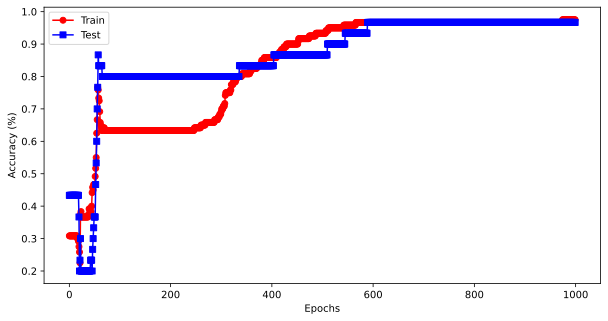

In [20]:
# Visualize the results
fig = plt.figure(figsize=(10, 5))

plt.plot(accuracies_train.detach(), "ro-")
plt.plot(accuracies_test.detach(), "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.show()

#### Perform Experiment

In [21]:
train_sizes = torch.linspace(0.5, 0.95, 10)
accuracies_train, accuracies_test = (
    torch.zeros(size=(train_sizes.shape[0], 1)),
    torch.zeros(size=(train_sizes.shape[0], 1)),
)

for idx, tr_size in enumerate(train_sizes):
    train_acc, test_acc = train_model(train_size=tr_size)
    accuracies_train[idx] = torch.mean(train_acc)
    accuracies_test[idx] = torch.mean(test_acc)

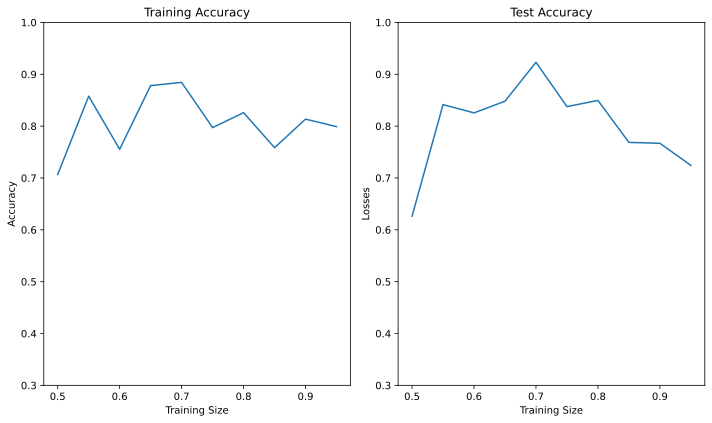

In [22]:
_, axs = plt.subplots(1, 2, figsize=(10, 6))
lower, upper = (0.3, 1)

axs[0].plot(train_sizes, accuracies_train.detach())
axs[0].set(xlabel="Training Size", ylabel="Accuracy", title="Training Accuracy")
axs[0].set_ylim(lower, upper)

axs[1].plot(train_sizes, accuracies_test.detach())
axs[1].set(xlabel="Training Size", ylabel="Losses", title="Test Accuracy")
axs[1].set_ylim(lower, upper)

plt.tight_layout()
plt.show()

#### Comment(s)

```
- It seems that changing the training size does not really impact the model performance
```

### Using Dataloader

```python
from torch.utils.data import DataLoader
```

In [23]:
# Create mock data
SIZE = 30
rng = np.random.default_rng(seed=123)

sample_data = rng.uniform(size=SIZE)
sample_labels = np.random.randint(low=0, high=2, size=SIZE)
sample_data, sample_labels

(array([0.68235186, 0.05382102, 0.22035987, 0.18437181, 0.1759059 ,
        0.81209451, 0.923345  , 0.2765744 , 0.81975456, 0.88989269,
        0.51297046, 0.2449646 , 0.8242416 , 0.21376296, 0.74146705,
        0.6299402 , 0.92740726, 0.23190819, 0.79912513, 0.51816504,
        0.23155562, 0.16590399, 0.49778897, 0.58272464, 0.18433799,
        0.01489492, 0.47113323, 0.72824333, 0.91860049, 0.62553401]),
 array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0]))

In [24]:
from torch.utils.data import DataLoader

# Instantiate
sample_data_loader = DataLoader(dataset=sample_data, shuffle=True)
print(sample_data_loader)

sample_data_loader.batch_size

1

In [25]:
for idx, _data in enumerate(sample_data_loader):
    if idx <= 5:
        print(f"{idx} data: {_data}\n")

0 data: tensor([0.5130], dtype=torch.float64)

1 data: tensor([0.9274], dtype=torch.float64)

2 data: tensor([0.4711], dtype=torch.float64)

3 data: tensor([0.2316], dtype=torch.float64)

4 data: tensor([0.0149], dtype=torch.float64)

5 data: tensor([0.1843], dtype=torch.float64)



#### Create A Dataset Object With The Labels Included

In [26]:
from torch.utils.data import TensorDataset

sample_dataset = TensorDataset(torch.tensor(sample_data), torch.tensor(sample_labels))

sample_dataset.tensors

(tensor([0.6824, 0.0538, 0.2204, 0.1844, 0.1759, 0.8121, 0.9233, 0.2766, 0.8198,
         0.8899, 0.5130, 0.2450, 0.8242, 0.2138, 0.7415, 0.6299, 0.9274, 0.2319,
         0.7991, 0.5182, 0.2316, 0.1659, 0.4978, 0.5827, 0.1843, 0.0149, 0.4711,
         0.7282, 0.9186, 0.6255], dtype=torch.float64),
 tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
         1, 1, 1, 0, 1, 0]))

In [27]:
for idx, (_data, _labels) in enumerate(sample_dataset):
    if idx <= 5:
        print(f"{idx} data: {_data} labels: {_labels}\n")

0 data: 0.6823518632481435 labels: 0

1 data: 0.053821018802222675 labels: 0

2 data: 0.22035987277261138 labels: 1

3 data: 0.1843718106986697 labels: 1

4 data: 0.17590590108503035 labels: 1

5 data: 0.8120945066557737 labels: 0



In [28]:
# Create a dataloader object
sample_data_loader = DataLoader(dataset=sample_dataset, shuffle=True)


# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    sample_data, sample_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((24,), (6,))

In [29]:
# Create datasets using the train and test data
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Convert the train and test data to DataLoader objects
train_DL = DataLoader(dataset=train_data, batch_size=4)
# Batch size is not required for the test_data
test_DL = DataLoader(dataset=test_data, batch_size=1)


# Examine the data with batch size.
# Each iteration contains 4 samples/tensors
for batch, label in train_DL:
    print(f"{batch},    data_size={batch.size()},    {label}\n")

tensor([0.8242, 0.1659, 0.2450, 0.5827]),    data_size=torch.Size([4]),    tensor([0., 0., 0., 0.])

tensor([0.7991, 0.1759, 0.1844, 0.1843]),    data_size=torch.Size([4]),    tensor([0., 1., 1., 1.])

tensor([0.9274, 0.7415, 0.2316, 0.8899]),    data_size=torch.Size([4]),    tensor([1., 0., 0., 1.])

tensor([0.6299, 0.0149, 0.6824, 0.0538]),    data_size=torch.Size([4]),    tensor([1., 1., 0., 0.])

tensor([0.4978, 0.5130, 0.5182, 0.2319]),    data_size=torch.Size([4]),    tensor([1., 1., 0., 0.])

tensor([0.9233, 0.9186, 0.2204, 0.2138]),    data_size=torch.Size([4]),    tensor([1., 1., 1., 0.])



In [30]:
for batch, label in test_DL:
    print(f"{batch},    data_size={batch.size()},    {label}\n")

tensor([0.2766]),    data_size=torch.Size([1]),    tensor([1.])

tensor([0.6255]),    data_size=torch.Size([1]),    tensor([0.])

tensor([0.8121]),    data_size=torch.Size([1]),    tensor([0.])

tensor([0.4711]),    data_size=torch.Size([1]),    tensor([1.])

tensor([0.8198]),    data_size=torch.Size([1]),    tensor([0.])

tensor([0.7282]),    data_size=torch.Size([1]),    tensor([0.])



### Train A Model With Batch Size

In [31]:
class Net(nn.Module):
    """This is used to build an Artificial Neural Network model."""

    def __init__(self, n_units: int) -> None:
        super().__init__()
        self.input = nn.Linear(4, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.softmax(self.output(X), dim=1)
        return X


def train_model(*, train_data: DataLoader, test_data: DataLoader) -> tuple[Any, Any]:
    """This is used to train the model using a batch size."""
    net = Net(n_units=32)
    learning_rate, epochs = 0.01, 1_000
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    batch_acc = []
    train_acc, test_acc = [], []

    # Iterate over the epochs
    for _ in np.arange(epochs):
        # Iterate over the batches
        for X_train, y_train in train_data:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            _y_proba = net(X_train)
            loss = criterion(_y_proba, y_train)

            # Back prop
            loss.backward()
            optimizer.step()

            # Compute training accuracy for the batch
            _y_pred = torch.argmax(_y_proba, axis=1)
            batch_acc.append(torch.mean((y_train == _y_pred).float().detach()))

        # Compute the training accuracy
        train_acc.append(np.mean(batch_acc))

        # Compute the test accuracy
        X_test, y_test = next(iter(test_data))
        y_pred_test = torch.argmax(net(X_test), axis=1)
        _acc = torch.mean((y_pred_test == y_test).float().detach())
        test_acc.append(_acc)

    return (train_acc, test_acc)

In [32]:
# Load Iris data
X, y = create_iris_data()

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
# Create Dataset
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create DataLoader
train_DL = DataLoader(dataset=train_data, batch_size=12, shuffle=True)
test_DL = DataLoader(
    dataset=test_data, batch_size=test_data.tensors[0].shape[0]
)  # entire data!

train_acc, test_acc = train_model(train_data=train_DL, test_data=test_DL)

Shape of X: torch.Size([150, 4]), Shape of X: torch.Size([150])


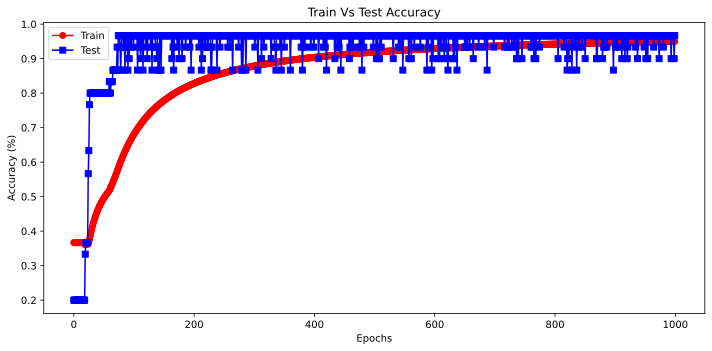

In [33]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(train_acc, "ro-")
plt.plot(test_acc, "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train Vs Test Accuracy")
plt.legend(["Train", "Test"])

plt.tight_layout()
plt.show()

<hr><br>

### Split The Data Into Train, Validation and Test Sets

```
- Training set: 
  - This is used for training the model. 
  - It's typically the largest proportion of the split.
  - The model overfits to this set.

- Validation set: 
  - This is used to optimize the model's performance. 
  - The model also overfits to this set.

- Test set: This is the last phase of model evalluation. 
  - It's used to evaluate the model only ONCE when we're satisfied with the hyperparameters and performance of the model. 
  - The model does not overfit to this set.

```

In [34]:
# Create mock data
SIZE = (70, 3)
rng = np.random.default_rng(seed=123)

sample_data = rng.uniform(size=SIZE)
sample_labels = np.random.randint(low=0, high=2, size=SIZE[0])
sample_data.shape, sample_labels.shape

((70, 3), (70,))

In [35]:
X_train, X_others, y_train, y_others = train_test_split(
    sample_data, sample_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_others.shape

((56, 3), (14, 3))

In [36]:
# Split the remainder into 2. i.e 50% for validation and test each.
X_validation, X_test, y_validation, y_test = train_test_split(
    X_others, y_others, test_size=0.5, random_state=RANDOM_STATE
)

X_validation.shape, X_test.shape

((7, 3), (7, 3))

### Regression With Hold Out Cross-validation

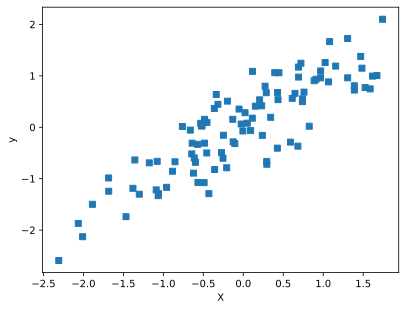

In [37]:
# Create data
N = 100
X = torch.randn(N, 1)
y = X + torch.randn(N, 1) / 2

# Visualize
plt.scatter(X, y, marker="s")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [38]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([80, 1]), torch.Size([20, 1]))

In [39]:
class Net(nn.Module):
    """This is an Artificial Neural Network used for regression."""

    def __init__(self, n_units: int) -> None:
        super().__init__()
        self.input = nn.Linear(1, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation.
        There's no non linearity since it's a linear data.
        """
        X = self.hidden(self.input(X))
        X = self.output(X)
        return X


def train_linear_model(*, X: torch.Tensor, y: torch.Tensor) -> tuple[Any, Any]:
    """This is used to train the model"""
    net = Net(n_units=8)
    learning_rate, epochs = 0.01, 500
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, losses = nn.MSELoss(), torch.zeros(size=(epochs,))

    for epoch_idx in np.arange(epochs):
        # Reset gradients
        optimizer.zero_grad()

        # Compute forward prop and loss
        _y_pred = net(X)
        loss = criterion(_y_pred, y)
        losses[epoch_idx] = loss

        # Back prop
        loss.backward()
        optimizer.step()

    return net, losses

In [40]:
linear_model, losses = train_linear_model(X=X_train, y=y_train)

# Make predictions
y_pred_train = linear_model(X_train)
y_pred_validation = linear_model(X_validation)

# Evaluate
mse_train = torch.mean(np.square(y_train - y_pred_train.detach()))
mse_validation = torch.mean(np.square(y_validation - y_pred_validation.detach()))


mse_train, mse_validation

(tensor(0.1971), tensor(0.2520))

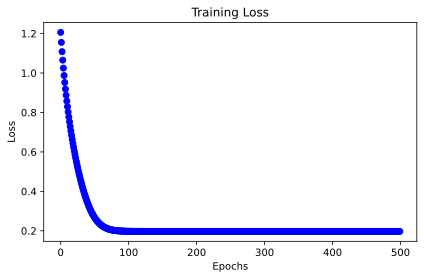

In [41]:
_, ax = plt.subplots(figsize=(6, 4))
ax.plot(losses.detach(), "bo")
ax.set(xlabel="Epochs", ylabel="Loss", title="Training Loss")
plt.tight_layout()
plt.show()

#### 2)  Practice Qs

```
Re-write this code to use DataLoader instead of using only scikit learn.
```

In [42]:
def train_linear_model(
    *, train_data_loader: DataLoader, validation_data_loader: DataLoader
) -> tuple[Any, Any]:
    """This is used to train the model"""
    net = Net(n_units=8)
    learning_rate, epochs = 0.01, 500
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, batch_loss = nn.MSELoss(), []
    train_losses, validation_losses = [], []

    for _ in np.arange(epochs):

        # Iterate through each batch
        for X_train, y_train in train_data_loader:
            # Reset gradients
            optimizer.zero_grad()

            # Compute forward prop and loss
            _y_pred = net(X_train)
            loss = criterion(_y_pred, y_train)

            # Back prop
            loss.backward()
            optimizer.step()

            # Compute training loss for the batch
            batch_loss.append(loss.detach())

        # Compute training loss
        train_losses.append(np.mean(batch_loss))

        # Compute the test loss
        X_val, y_val = next(iter(validation_data_loader))
        y_pred_val = linear_model(X_val)
        mse_val = torch.mean(torch.square(y_val - y_pred_val))
        validation_losses.append(mse_val.detach())

    return (train_losses, validation_losses)

In [43]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Dataset object
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
validation_data = TensorDataset(torch.Tensor(X_validation), torch.Tensor(y_validation))

# Dataloader object
train_DL = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
)

In [45]:
train_losses, validation_losses = train_linear_model(
    train_data_loader=train_DL, validation_data_loader=validation_DL
)

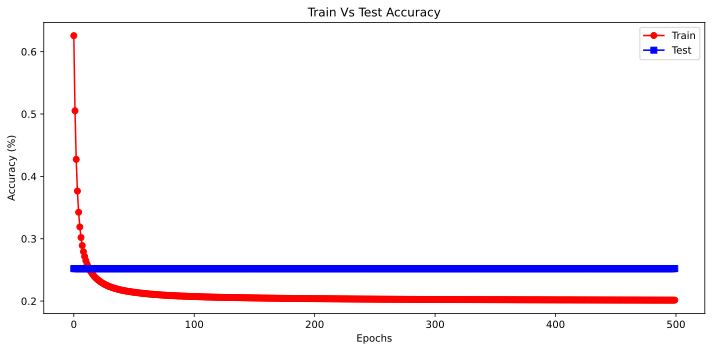

In [46]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(train_losses, "ro-")
plt.plot(validation_losses, "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train Vs Test Accuracy")
plt.legend(["Train", "Test"])

plt.tight_layout()
plt.show()